# Finding Aliens with MobileNetV2 and Isolation Forest

---

Data from 

https://www.spacetelescope.org/projects/fits_liberator/m31data/

Cut into smaller square sub-images with ImageMagick

```
convert m31_composite_cropped.png -crop 112x112 +repage  +adjoin data/crop_112/m31_composite_112_112_%03d.png
```

![grid](https://i.imgur.com/IaPTwSN.jpg)

In [2]:
import numpy as np

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

## MobileNetV2 - A very good performance/speed balance

MobileNetV2 is a nice and small NeuralNet, very easy to apply for (transferlearning) with Keras
https://keras.io/applications/#mobilenetv2

![Architecturs](https://i.imgur.com/MLupqOl.png)

(from 08506339_Benchmark Analysis of Representative Deep_Neural Network Architectures )

In [3]:
mobilenet_without_top = MobileNetV2(weights='imagenet', include_top=False, pooling="max")
mobilenet_with_top = MobileNetV2(weights='imagenet', include_top=True)

/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:306: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


14540800/14536120 [==============================] - 0s 0us/step


## Load data

In [4]:
import types
import pandas as pd

In [6]:
%%capture unzip_files
!unzip -o data.zip

In [7]:
from tensorflow.keras.preprocessing import image

## Test ImageNetV2 by feeding it a telescope

Loading the image with `load_img()`, `img_to_array()`, from `preprocessing` 

https://keras.io/preprocessing/image/

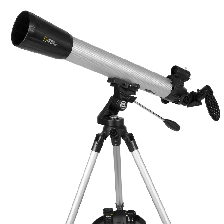

In [8]:
telescope = image.load_img("data/telescope.png", target_size=(224,224) )
np_telescope = preprocess_input(image.img_to_array(telescope))
telescope

In [9]:
output_mobile = mobilenet_with_top.predict(np.expand_dims(np_telescope, axis=0))

In [10]:
decode_predictions(output_mobile)

40960/35363 [==================================] - 0s 1us/step


[[('n04485082', 'tripod', 0.44680414),
  ('n03759954', 'microphone', 0.37267816),
  ('n02841315', 'binoculars', 0.03320192),
  ('n02950826', 'cannon', 0.0043956046),
  ('n03126707', 'crane', 0.003559197)]]

The predictions seem fair - MobileNetV2 is loaded correctly.


---

## Use the MobileNet to transfer each image to a array of size 1280

Apparently these 1280 doubles are good information to predict 1000 categories from ImageNet (over 14 Million images)


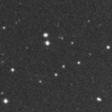

In [11]:
random_small_image_from_space = image.load_img("data/crop_112/m31_composite_112_112_000.png")
random_small_image_from_space

In [14]:
np_image_small = preprocess_input(image.img_to_array(random_small_image_from_space))
output_mobile_small = mobilenet_without_top.predict(np.expand_dims(preprocess_input(np_image_small), axis=0))

In [16]:
output_mobile_small

array([[-4.277975 , -2.9587674, -6.756191 , ..., -6.8399844,  1.1363885,
        -2.8584988]], dtype=float32)

In [17]:
output_mobile_small.shape

(1, 1280)

## Load all Images - and let MobileNet transform them to arrays over size 1280

In [18]:
import os

png_files = [file for file in os.listdir("data/crop_112/") if ".png" in file ]

In [19]:
m31_images = []

for png_filename in png_files:
    image_path = "data/crop_112/" + png_filename
    m31_images.append(preprocess_input(image.img_to_array(image.load_img(image_path, target_size=(112,112)))))

In [21]:
np_m31_images = np.array(m31_images)
np_m31_images.shape

(992, 112, 112, 3)

## Usually (thx to GPU) all 992 images are processed in under a second

In [23]:
%%time
raw_mobilenet_signals = mobilenet_without_top.predict(np_m31_images)

CPU times: user 708 ms, sys: 168 ms, total: 876 ms
Wall time: 796 ms


## First Dimension Reduction Step - PCA 1280 -> 50 

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [24]:
%%time

from sklearn.decomposition import PCA

pca = PCA(n_components=50)
PCA_m31 = pca.fit_transform(raw_mobilenet_signals)

CPU times: user 5.53 s, sys: 3.29 s, total: 8.82 s
Wall time: 2.52 s


## Second Dimension Reduction Step - t-SNE 50 -> 2

2 Dimensions to create a nice plot, where each dot represents a 112x112 image

In [25]:
from sklearn.manifold import TSNE

In [26]:
%%time
X_embedded = TSNE(n_components=2,verbose=1).fit_transform(PCA_m31)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 992 samples in 0.003s...
[t-SNE] Computed neighbors for 992 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 992 / 992
[t-SNE] Mean sigma: 20.948948
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.542854
[t-SNE] Error after 1000 iterations: 1.111082
CPU times: user 19.3 s, sys: 15.5 s, total: 34.8 s
Wall time: 34.8 s


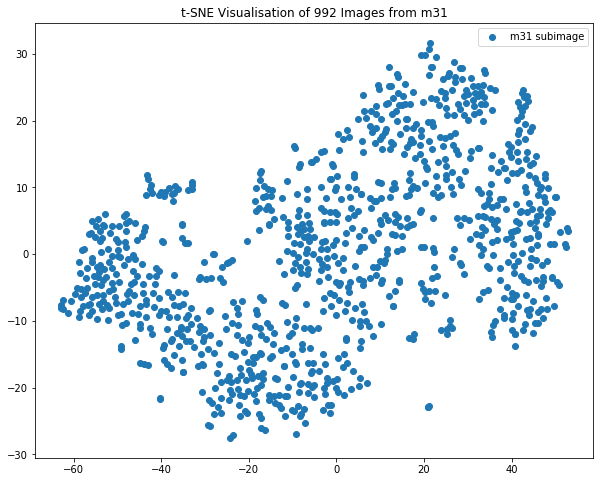

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(x=X_embedded[:,0],y=X_embedded[:,1], label="m31 subimage")
plt.title("t-SNE Visualisation of 992 Images from m31")
plt.legend()
plt.show()

# Isolation Forest applied on 50 PCA components

In [29]:
%%time

from sklearn.ensemble import IsolationForest

isof = IsolationForest(n_estimators=100)
isof.fit(PCA_m31)
isolation_anomaly_index = isof.decision_function(PCA_m31)

CPU times: user 288 ms, sys: 0 ns, total: 288 ms
Wall time: 289 ms


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


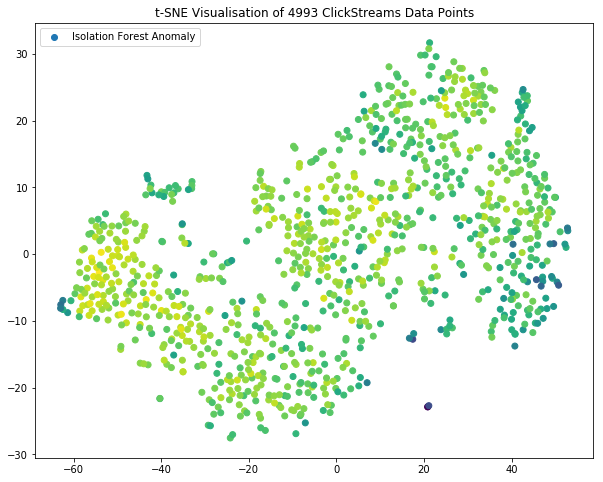

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.scatter(x=X_embedded[:,0],y=X_embedded[:,1],c=isolation_anomaly_index, label="Isolation Forest Anomaly")
plt.title("t-SNE Visualisation of 4993 ClickStreams Data Points")
plt.legend()
plt.show()

In [31]:
sorted(zip(range(len(isolation_anomaly_index)), isolation_anomaly_index) , key=lambda x:x[1])[:4]

[(783, -0.10451081924118522),
 (658, -0.08696262180144287),
 (613, -0.05498696329527808),
 (939, -0.052638723093686335)]

In [32]:
potential_aliens = sorted(zip(range(len(isolation_anomaly_index)), isolation_anomaly_index) ,key=lambda x:x[1])[:4]

potential_aliens_images = []

for image_index in [index for (index,iso) in potential_aliens]:
    print(image_index)
    potential_aliens_images.append(image.load_img("data/crop_112/m31_composite_112_112_{}.png".format(image_index)))

783
658
613
939


# View the alien found with Isolation Forest


![alien](https://i.imgur.com/bw1WxCW.jpg)

# Let's Enhance

![enhance](https://i.imgur.com/UAFdTg6.jpg)
https://letsenhance.io/
    
https://imgur.com/a/YMxZaXu
    
![enhanced](https://i.imgur.com/9pWroVa.jpg)

![whatisit](https://i.imgur.com/L2inZjC.png)